In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import re  
import warnings
import os 
warnings.filterwarnings("ignore")
%matplotlib inline
plt.rcParams['figure.figsize'] = [8,5]
plt.rcParams['font.size'] =14
plt.rcParams['font.weight']= 'bold'
sns.set()

In [2]:
import torch
import torch.nn as n 
import torch.optim as optim
import torch.nn.functional as F 
from torch.utils.data import DataLoader 
import torchvision.datasets as datasets 
import torchvision.transforms as tt
import torchtext
from textblob import TextBlob 
from wordcloud import WordCloud

In [4]:
df = pd.read_csv("./Dataset/Train.csv")
df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


##Some Basic Insights:


*   What is the outlet that made the most money?
*   Does Outlet_Type affect sales?
*   Does Outlet_Location_Type affect sales?
*   What is the item type that produced the most money?
*   What is the most sold product?





In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


### We can see that "Item_Weight" & "Outlet_Type" contain null values. Therefore, we need to fill these values. We want to find columns that are correlated to these two columns to use IterativeImputer. Or, we could fill them using the mean value.

In [6]:
df['Item_Fat_Content'].unique()

array(['Low Fat', 'Regular', 'low fat', 'LF', 'reg'], dtype=object)

In [7]:
dic = {
    "Low Fat" : "low fat",
    "LF" : "low fat",
    "low fat" : "low fat",
    "reg" : "Regular",
    "Regular" : "Regular",
}
df['Item_Fat_Content'].map(dic).unique()

array(['low fat', 'Regular'], dtype=object)

In [8]:
df['Item_Fat_Content'] = df['Item_Fat_Content'].map(dic)

In [9]:
df['Item_MRP'].corr(df['Item_Weight'])
#weak correlation since it is not 1 or -1 or close to them.

0.027141153883330566

In [10]:
df['Item_Weight'].fillna(df['Item_Weight'].mean(), inplace = True)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                8523 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


###Insight 1:

In [12]:
print(df["Outlet_Identifier"].unique())
df["Outlet_Identifier"].nunique()

['OUT049' 'OUT018' 'OUT010' 'OUT013' 'OUT027' 'OUT045' 'OUT017' 'OUT046'
 'OUT035' 'OUT019']


10

In [13]:
highest_selling_outlet = df.groupby("Outlet_Identifier")["Item_Outlet_Sales"].sum().sort_values(ascending = False)

<BarContainer object of 10 artists>

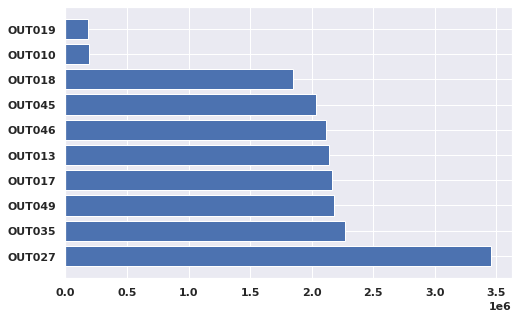

In [14]:
plt.barh(highest_selling_outlet.index, highest_selling_outlet.values)

###Insight 2:

In [15]:
hold = df[~((df["Outlet_Identifier"] == "OUT010") | (df["Outlet_Identifier"] == "OUT019"))].copy()

In [16]:
hold[hold["Outlet_Identifier"] == "OUT027"]["Outlet_Type"].value_counts()

Supermarket Type3    935
Name: Outlet_Type, dtype: int64

####We can see that the highest selling outlet is a Supermarket Type3.

In [17]:
hold[~(hold["Outlet_Identifier"] == "OUT027")]["Outlet_Type"].value_counts()

Supermarket Type1    5577
Supermarket Type2     928
Name: Outlet_Type, dtype: int64

####We can see that all the other are of type 1 and 2. Therefore, type 3 sells more.

In [18]:
hold.groupby("Outlet_Type")["Item_Outlet_Sales"].mean()

Outlet_Type
Supermarket Type1    2316.181148
Supermarket Type2    1995.498739
Supermarket Type3    3694.038558
Name: Item_Outlet_Sales, dtype: float64

####We can also see that type 1 is better at sales than type 2.

###Insight 3:

In [20]:
df.groupby("Outlet_Location_Type")["Item_Outlet_Sales"].mean()

Outlet_Location_Type
Tier 1    1876.909159
Tier 2    2323.990559
Tier 3    2279.627651
Name: Item_Outlet_Sales, dtype: float64

####Insight 4:

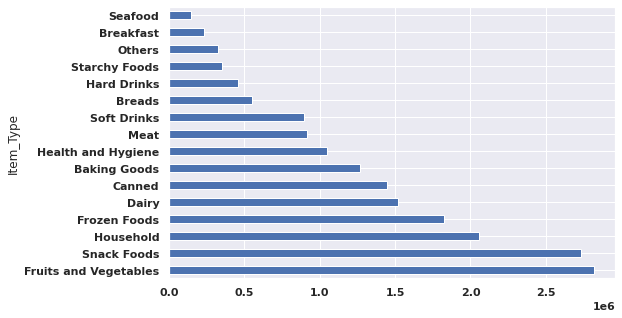

In [24]:
df.groupby("Item_Type")["Item_Outlet_Sales"].sum().sort_values(ascending = False).plot(kind = "barh")

####We can also check what is the item that produced the most amount of money in each outlet

In [27]:
df.groupby(["Outlet_Identifier","Item_Type"])["Item_Outlet_Sales"].sum()

Outlet_Identifier  Item_Type    
OUT010             Baking Goods      10693.4138
                   Breads             7657.3658
                   Breakfast          4081.3540
                   Canned             9019.5926
                   Dairy             15307.4078
                                       ...     
OUT049             Others            47772.4816
                   Seafood           11827.2712
                   Snack Foods      350244.0900
                   Soft Drinks       97585.6402
                   Starchy Foods     42019.9696
Name: Item_Outlet_Sales, Length: 160, dtype: float64

In [29]:
#To see the whole result when using multiindexed groupby, use unstack()
df.groupby(["Outlet_Identifier","Item_Type"])["Item_Outlet_Sales"].sum().unstack().T

Outlet_Identifier,OUT010,OUT013,OUT017,OUT018,OUT019,OUT027,OUT035,OUT045,OUT046,OUT049
Item_Type,,,,,,,,,,
Baking Goods,10693.4138,149715.7828,147731.0330,121065.0772,14133.6024,224172.1968,135005.5976,150368.9326,173376.3174,139263.3886
Breads,7657.3658,52018.2882,49008.8722,54604.9212,4947.5598,110518.8052,76456.4772,65663.8592,71870.4468,60490.5932
Breakfast,4081.3540,27355.7246,24436.1916,22496.0504,3762.4358,50432.3526,31117.4946,21802.9526,16599.7256,30214.6698
Canned,9019.5926,143732.2382,175853.0934,145681.7006,16739.5436,272150.4106,195444.2584,174307.7716,173084.6970,138138.1866
Dairy,15307.4078,196254.5370,185955.2768,152130.6394,16144.3184,262317.2104,185067.7654,154650.0266,175086.0918,179680.7776
Frozen Foods,17942.6442,203696.8494,239347.1104,183599.0106,15252.8122,316272.3108,213487.4384,177020.2408,243236.7140,215879.6578
Fruits and Vegetables,24548.0460,341526.7706,319504.1040,263471.7076,24054.0224,576028.1886,304647.4428,326414.4422,304751.3076,335113.7850
Hard Drinks,4067.3722,54362.5700,55432.5106,49445.6370,1768.3648,78957.8878,49941.6580,56274.0818,44615.9238,62927.4212
Health and Hygiene,13570.3356,119135.5888,124751.6118,108845.6498,10945.0862,199084.1870,118230.7666,104603.1722,133189.2952,112844.4446


In [30]:
hold_2 = df.groupby(["Outlet_Identifier","Item_Type"])["Item_Outlet_Sales"].sum().unstack().T.copy()

In [31]:
hold_2.head()

Outlet_Identifier,OUT010,OUT013,OUT017,OUT018,OUT019,OUT027,OUT035,OUT045,OUT046,OUT049
Item_Type,,,,,,,,,,
Baking Goods,10693.4138,149715.7828,147731.0330,121065.0772,14133.6024,224172.1968,135005.5976,150368.9326,173376.3174,139263.3886
Breads,7657.3658,52018.2882,49008.8722,54604.9212,4947.5598,110518.8052,76456.4772,65663.8592,71870.4468,60490.5932
Breakfast,4081.3540,27355.7246,24436.1916,22496.0504,3762.4358,50432.3526,31117.4946,21802.9526,16599.7256,30214.6698
Canned,9019.5926,143732.2382,175853.0934,145681.7006,16739.5436,272150.4106,195444.2584,174307.7716,173084.6970,138138.1866
Dairy,15307.4078,196254.5370,185955.2768,152130.6394,16144.3184,262317.2104,185067.7654,154650.0266,175086.0918,179680.7776


In [34]:
outlet_highest_product = {}
for i in hold_2.columns:
  x = hold_2[i].sort_values(ascending = False)
  outlet_highest_product[i] = (x.index[0],x[0])

In [35]:
outlet_highest_product

{'OUT010': ('Snack Foods', 25942.897),
 'OUT013': ('Fruits and Vegetables', 341526.7706),
 'OUT017': ('Fruits and Vegetables', 319504.104),
 'OUT018': ('Snack Foods', 278714.5328),
 'OUT019': ('Snack Foods', 25653.274),
 'OUT027': ('Fruits and Vegetables', 576028.1886),
 'OUT035': ('Snack Foods', 355573.819),
 'OUT045': ('Fruits and Vegetables', 326414.4422),
 'OUT046': ('Fruits and Vegetables', 304751.3076),
 'OUT049': ('Snack Foods', 350244.09)}

####Insight 5

In [39]:
df.groupby("Item_Identifier")["Item_Outlet_Sales"].sum().sort_values(ascending = False)

Item_Identifier
FDY55    42661.8008
FDA15    41584.5364
FDZ20    40185.0248
FDF05    36555.7490
FDA04    35741.4756
            ...    
FDQ04      784.3124
FDF38      771.6622
FDY43      673.7896
NCR42      332.9000
FDQ60      120.5098
Name: Item_Outlet_Sales, Length: 1559, dtype: float64

####We still need to finish filling the null values of the dataset

In [69]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                8523 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


In [70]:
df["Outlet_Size"].unique()

array(['Medium', nan, 'High', 'Small'], dtype=object)

In [72]:
df.groupby("Outlet_Type")["Outlet_Size"].value_counts()

Outlet_Type        Outlet_Size
Grocery Store      Small           528
Supermarket Type1  Small          1860
                   High            932
                   Medium          930
Supermarket Type2  Medium          928
Supermarket Type3  Medium          935
Name: Outlet_Size, dtype: int64